In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction
For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file. 

This notebook demonstrates how to run PODPAC Pipeline on AWS Lambda. Specifically, we will:
* Create a node
* Execute the node on AWS Lambda

**This example requires a pre-configured AWS Lambda node.** We will not cover how the AWS Lambda node was created. For more details see the [AWS Lambda Tutorial](../developer/aws-lambda-tutorial.ipynb). 

# How to run analysis on AWS Lambda
* Make sure you have PODPAC properly installed WITH the **aws** optional dependencies: `pip install podpac[aws]`

<i style='font-size:18pt'>PODPAC uses the Python package `boto3` to interact with an S3 bucket which triggers the Lambda function execution. It also uses `boto3` to monitor an S3 bucket for the computed output. </i>


<img src='../Images/PODPAC-AWS-Lambda.png' style='width:80%; margin-left:auto;margin-right:auto' />

In [2]:
import podpac

# Setup (1/2)
* Configure AWS credentials
* I have these already in my local `setting.py` file

In [3]:
# Configure AWS Settings

# podpac.settings.S3_BUCKET_NAME = $YOUR_BUCKET_NAME
# podpac.settings.S3_JSON_FOLDER = 'json/' # Or the S3 folder you'd like JSON to be uploaded to.
# podpac.settings.S3_OUTPUT_FOLDER = 'output/' # Or the S3 folder you'd like outputs to be uploaded to.
# podpac.settings.AWS_ACCESS_KEY_ID = $YOUR_ACCESS_KEY_ID
# podpac.settings.AWS_SECRET_ACCESS_KEY = $YOUR_SECRET_ACCESS_KEY
# podpac.settings.AWS_REGION_NAME = $YOUR_REGION_NAME

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html).

In [4]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

Username: mpuecker
Password: ··················


# Setup (2/2)
* Create the PODPAC Pipeline
* We're using the same pipeline from the [Analyzing SMAP Data](../basic_examples/analyzing-SMAP-data.ipynb) notebook
* This example computes the difference between the current soil moisture for a region, and that of the previous year

In [5]:
# Create the Pipeline
product = 'SPL4SMAU'   
sm = podpac.datalib.SMAP(product=product, username=username, password=password)
sm_time1_offset = podpac.algorithm.ExpandCoordinates(source=sm, time=['-1,Y', '-1,Y'])
sm_offset = podpac.algorithm.Mean(source=sm_time1_offset, dims=['time'])

# This is the output Node of the Pipeline
diff = podpac.algorithm.Arithmetic(eqn='B-A', A=sm, B=sm_offset)

# Create PODPAC Coordinates 
* This specifies the region and date where the pipeline will be evaluated

In [6]:
# Specify region of interest on a uniform grid
lat = podpac.crange(  60,  10, -2.0)  # (start, stop, step)
lon = podpac.crange(-130, -60,  2.0)  # (start, stop, step)

# Specify date and time
time = '2018-05-19T12:00:00'

# Create the PODPAC Coordinates
coords = podpac.Coordinates([lat, lon, time], dims=['lat', 'lon', 'time'])

# Evaluating node on AWS cloud 

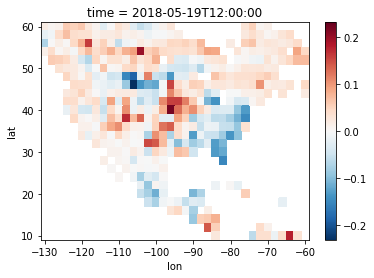

In [7]:
aws_lambda_manager = podpac.core.managers.aws_lambda.Lambda(source=diff)
o_aws = aws_lambda_manager.eval(coords)
o_aws.plot()